In [22]:
import os
import nibabel as nib
import numpy as np
import nilearn
from nilearn import image
import pandas as pd
from hampel import hampel
import scipy.stats as stats
import matplotlib.pyplot as plt

In [23]:
# sub = 'all'
# data_dir = '/arc/project/st-ipor-1/mkhademi/BOLD5000_2.0/'
# output_dir = '/scratch/st-ipor-1/mkhademi/'
output_dir = 'C:\\Users\\mahkh\\Documents\\'
roi_dir = output_dir + 'image_data\\parcels\\'
subjs = ['CSI1', 'CSI2', 'CSI3', 'CSI4']
sub = subjs[2]
roi_names = ['lFFA','rFFA','lOFA','rOFA','lSTS','rSTS','lLOC','rLOC','lPPA','rPPA','lRSC','rRSC','lTOS','rTOS','lEBA','rEBA']
roi_voxels = {'lFFA': 531, 'rFFA': 1019, 'lOFA': 211, 'rOFA': 790, 'lSTS': 844, 'rSTS': 2505, 'lLOC': 4971, 'rLOC': 5085,
             'lPPA': 732, 'rPPA': 553, 'lRSC': 1063, 'rRSC': 1741, 'lTOS': 133, 'rTOS': 251, 'lEBA': 2155, 'rEBA': 2413}
supcat_names = {91: 'vehicle', 93: 'animal', 0: 'person', 90: 'face', 92: 'outdoor', 95: 'sport', 97: 'food', 
                98: 'furniture',102: 'tool'}

In [24]:
def get_med_rois(sub, j):
    igs = nib.load(output_dir + 'image_data\\vis_\\igs-p-' + sub + '-c' + str(j) + '.nii.gz')
    #igs = nilearn.image.resample_img(igs, target_shape=(91, 109, 91), target_affine=igs.affine)
    mtx = igs.affine
    igs = np.array(igs.dataobj)
    #dif = dif[6:91-6, 7:109-7, 11:91-11]
    med_rois = []
    no_roi = np.ones((91, 109, 91), dtype=np.uint8)
    for roi_name in roi_names:
        roi = nib.load(roi_dir + roi_name + '_.nii.gz')
        roi = nilearn.image.resample_img(roi, target_shape=(91, 109, 91), target_affine=mtx)
        roi = np.array(roi.dataobj)
        no_roi[np.nonzero(roi)] = 0
        tmp = igs[np.nonzero(roi)]
        tmp[tmp == 0.0] = np.nan
        med_rois.append(np.nanmedian(tmp))
    return med_rois

In [25]:
def get_prop(sub, j):
    igs = nib.load(output_dir + 'image_data\\vis_\\igs-p-' + sub + '-c' + str(j) + '.nii.gz')
    mtx = igs.affine
    igs = np.array(igs.dataobj)
    #igs = igs[6:91-6, 7:109-7, 11:91-11]

    tmp = igs.reshape(-1)
    tmp[tmp == 0.0] = np.nan
    tmp = tmp[~np.isnan(tmp)]
    p_pos = np.nanpercentile(tmp, 80)
    print("p_80", p_pos)
    n_p_pos = 0
    for x in tmp:
        if x > p_pos:
            n_p_pos += 1
    p_neg = np.nanpercentile(tmp, 20)
    print("p_20", p_neg)
    n_p_neg = 0
    for x in tmp:
        if x < p_neg:
            n_p_neg += 1

    igs_rois = []
    all_prop_pos = []
    all_prop_neg = []
    no_roi = np.ones((91, 109, 91), dtype=np.uint8)
    for roi_name in roi_names:
        roi = nib.load(roi_dir + roi_name + '_.nii.gz')
        #
        roi = nilearn.image.resample_img(roi, target_shape=(91, 109, 91), target_affine=mtx)
        #
        roi = np.array(roi.dataobj)
        no_roi[np.nonzero(roi)] = 0
        tmp = igs[np.nonzero(roi)].copy()
        tmp[tmp == 0.0] = np.nan
        tmp = tmp[~np.isnan(tmp)]
        igs_rois.append(np.nanmedian(tmp))
        prop = 0.0
        for x in tmp:
            if x >= p_pos:
                prop += 1
        if len(tmp) > 0:
            all_prop_pos.append(prop/len(tmp))
            # all_prop_pos.append(prop/n_p_pos)
        else:
            all_prop_pos.append(0.0)
        prop = 0.0
        for x in tmp:
            if x <= p_neg:
                prop += 1
        if len(tmp) > 0:
            all_prop_neg.append(prop/len(tmp))
            # all_prop_neg.append(prop/n_p_neg)
        else: 
            all_prop_neg.append(0.0)
   
    return all_prop_pos

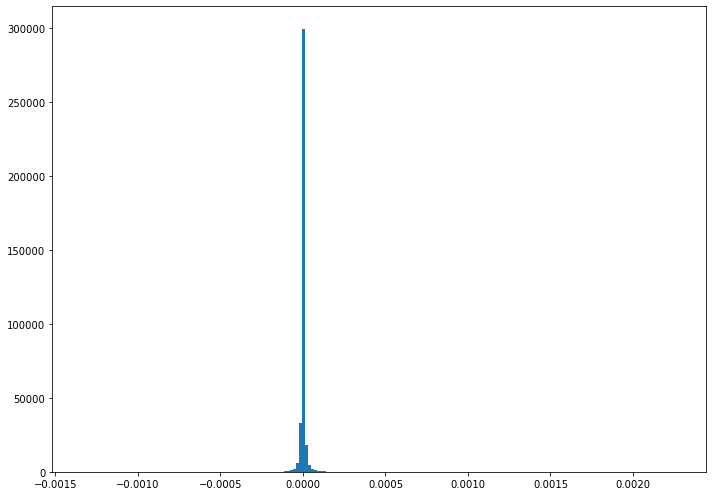

In [26]:
j = 90
igs = nib.load(output_dir + 'image_data/vis/igs-p-' + sub + '-c' + str(j) + '.nii.gz') 
igs = nilearn.image.resample_img(igs, target_shape=(91, 109, 91), target_affine=igs.affine)
igs = np.array(igs.dataobj)
#igs = igs[6:91-6, 7:109-7, 11:91-11]
tmp = igs.reshape(-1)
tmp[tmp == 0.0] = np.nan
tmp = tmp[~np.isnan(tmp)]
fig, axs = plt.subplots(1, 1, figsize =(10, 7), tight_layout = True)
axs.hist(tmp, bins=200)
# Show plot
plt.show()

In [27]:
def plot_igs(x_yes, y):
    fig = plt.figure()
    fig.set_size_inches(10, 4)
    plt.rc('font', size=10)
    ax = fig.add_axes([0,0,1,1])
    ax.set_ylabel(y)
    ax.set_xlabel('Brain ROIs')
    ax.set_title(sub + ': ' + supcat_names[j])
    x_pos = np.arange(len(roi_names))*5
    ax.bar(x_pos, x_yes, align='center', color='blue', alpha=0.8, ecolor='black', capsize=10, width=2)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(roi_names)
    plt.show()

In [28]:
def plot_all(sub, j):
    all_prop_pos_yes = get_prop(sub, j)
    all_prop_pos_yes = np.array(all_prop_pos_yes)
    all_prop_pos_yes = all_prop_pos_yes/all_prop_pos_yes.sum()
    
    plot_igs(all_prop_pos_yes, 'Proportion: Greater Than 80th Percentile')
    med_rois = get_med_rois(sub, j)
    plot_igs(med_rois, 'Median of IGs')
    return

p_80 1.0623970229062264e-05
p_20 -9.210888674715531e-06


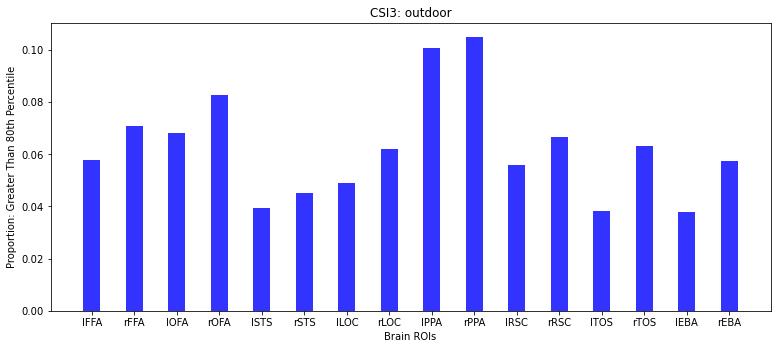

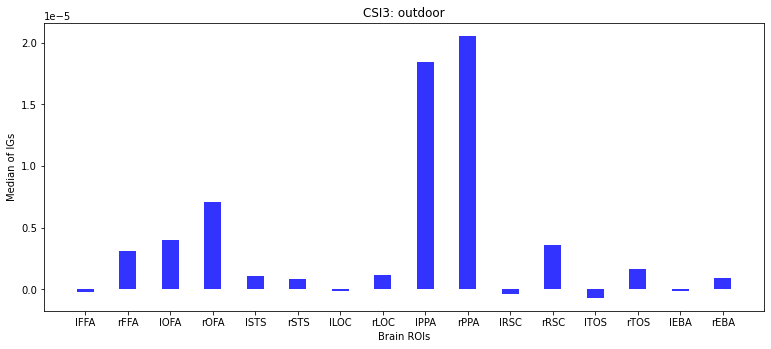

In [37]:
j = 92 # outdoor
plot_all(sub, j)

p_80 3.670464275273844e-06
p_20 -3.2509460652363487e-06


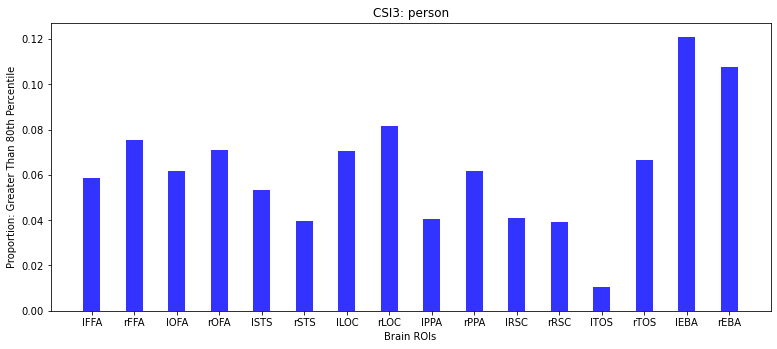

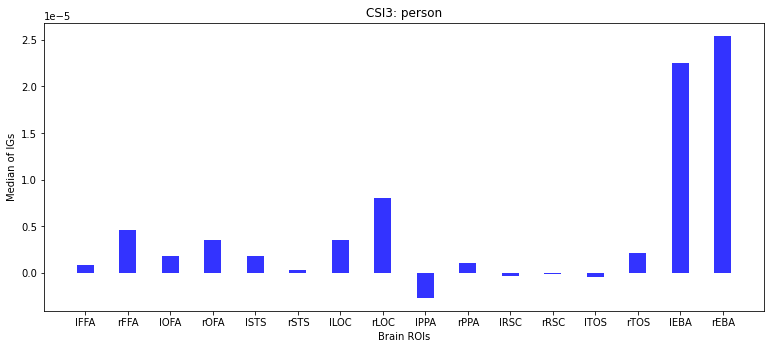

In [30]:
j = 0 # person
plot_all(sub, j)

p_80 7.675174856558447e-06
p_20 -6.926702099008253e-06


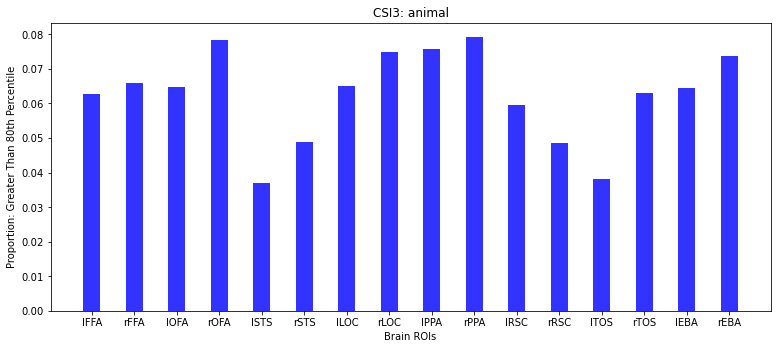

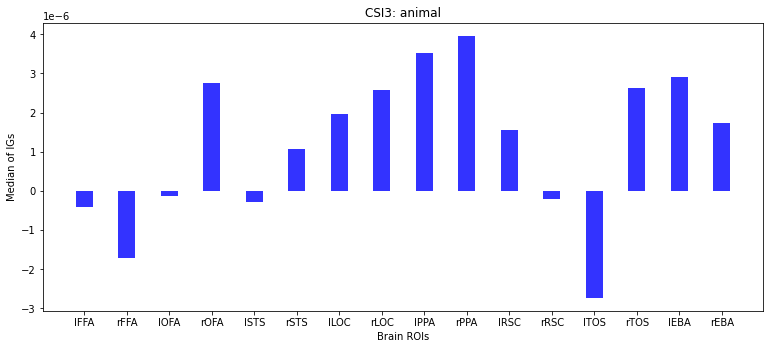

In [31]:
j = 93 # animal
plot_all(sub, j)

p_80 3.4728614991763616e-06
p_20 -2.9420868941087966e-06


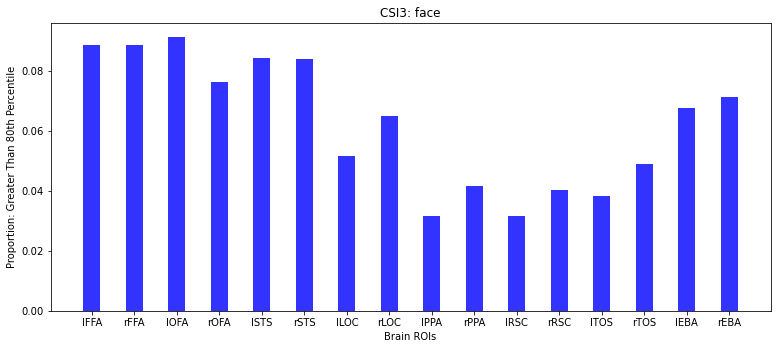

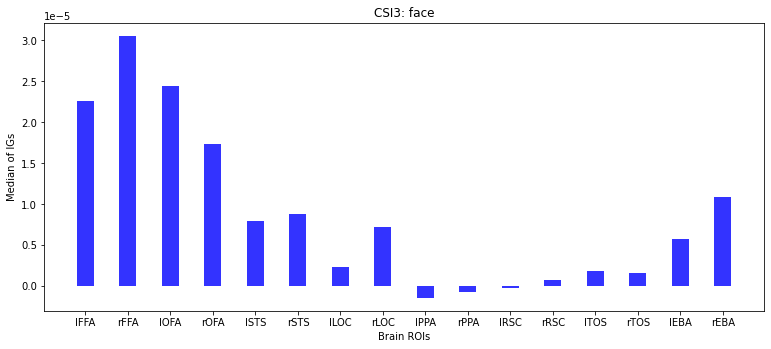

In [32]:
j = 90 # face
plot_all(sub, j)

p_80 9.588348984834742e-06
p_20 -8.63378354551969e-06


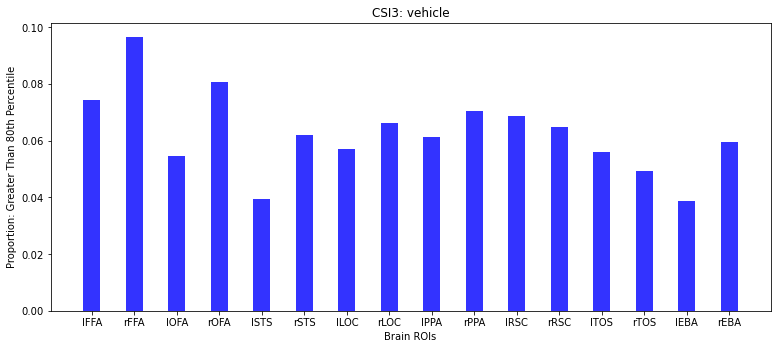

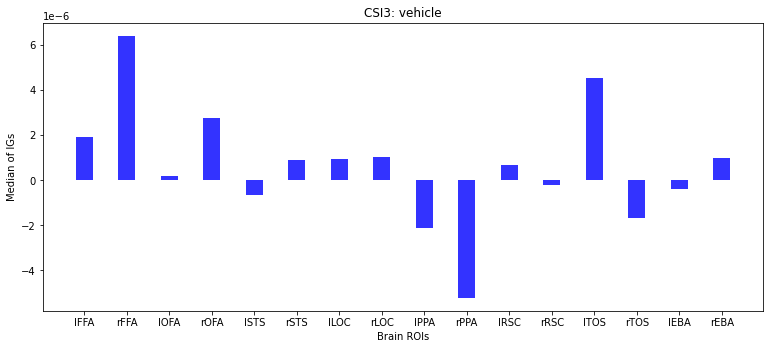

In [33]:
j = 91  # vehicle
plot_all(sub, j)

p_80 8.949159928306465e-06
p_20 -7.861467565817293e-06


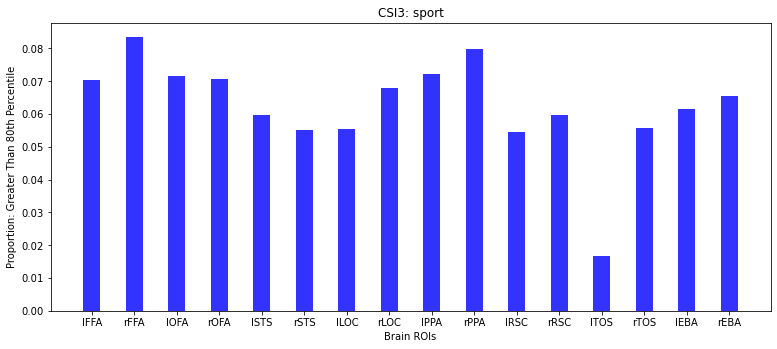

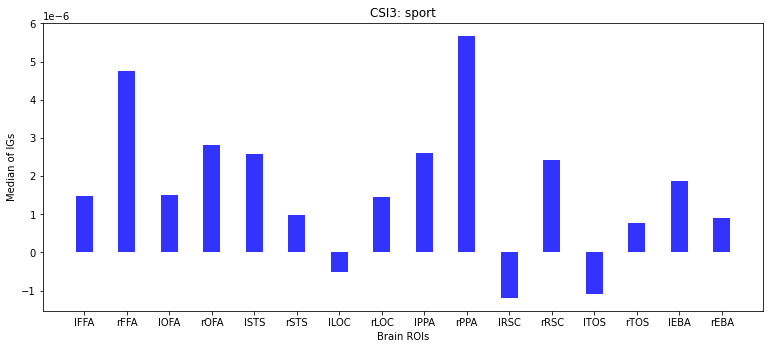

In [34]:
j = 95 # sport
plot_all(sub, j)

p_80 8.88357317307964e-06
p_20 -7.467931936844252e-06


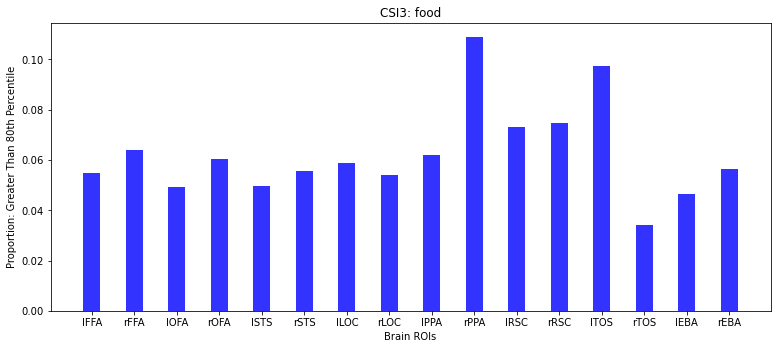

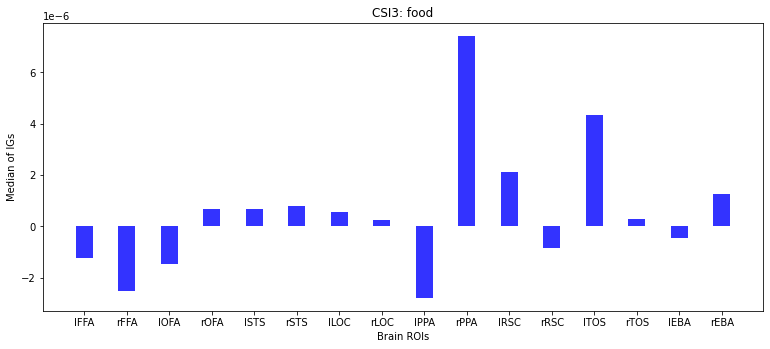

In [35]:
j = 97 # food
plot_all(sub, j)

p_80 1.177943231596146e-05
p_20 -1.067703797161812e-05


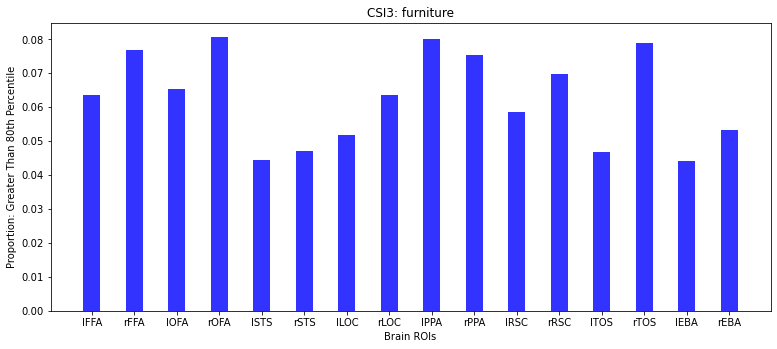

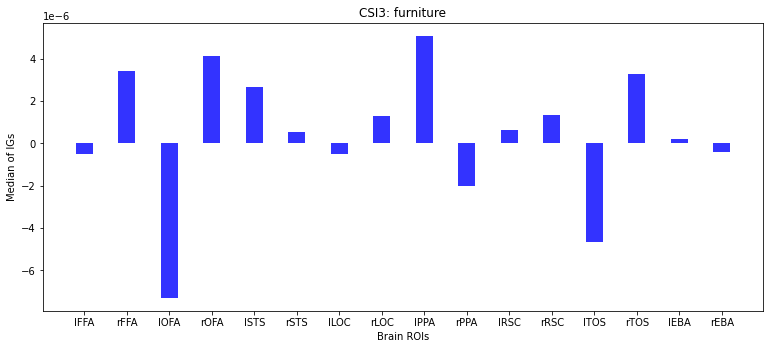

In [36]:
j = 98 # furniture
plot_all(sub, j)